In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import PIL.Image as Image  # Correct PIL import
import time
import subprocess
import time
import cv2
import base64
from IPython.display import HTML
import IPython.display as display
from IPython.display import Video
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from plotting_module import plot_variations
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import json

print('Importing libraries finished', flush=True)

In [ ]:
# Get Video Properties
# Load the video file
video_path = "ExampleVideo.mp4"  # Change this to your video file path
cap = cv2.VideoCapture(video_path)

# Get video properties
if cap.isOpened():
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


    print(f"Video Information:")
    print(f" - File Path: {video_path}")
    print(f" - Frame Count: {frame_count}")
    print(f" - FPS: {fps:.2f}")
    print(f" - Duration: {duration:.2f} seconds")
    print(f" - Resolution: {width}x{height}")

else:
    print("Error: Unable to open video file.")

# Release the video capture object
cap.release()


In [ ]:
# Pupil Detection
cap = cv2.VideoCapture(video_path)

# Choose the frame number to extract
frame_number = 240  # Change this to your desired frame number

# Calculate the timestamp of the frame in seconds
time_in_seconds = frame_number / fps if fps > 0 else 0

# Set the video to the chosen frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.axis("off")  # Hide axes
plt.title(f"Frame: {frame_number}, Time: {time_in_seconds:.2f} sec")
plt.show()





### Image Preprocessing

Before applying thresholding to detect the pupil, we can enhance the input frame by preprocessing it. This step is crucial because it:

1. **Simplifies the Image:**
   - Converting the image to grayscale reduces the data complexity and focuses on intensity variations.
2. **Reduces Noise:**
   - Applying a Gaussian blur smoothens the image and minimizes the impact of high-frequency noise. This helps prevent false edges in the thresholded image. Removes small pixel-level fluctuations or noise (like reflections, eyelashes, or sensor noise)
3. **Refines Region Shape:**
   - Morphological operations (such as opening) remove small artifacts and improve the shape of the detected region, which is beneficial when later determining the best-fit circle.


In [ ]:
# Preprocessing
# 1. Convert the frame to grayscale.
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 2. Apply Gaussian Blur to reduce noise.
blurred_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

# 3. Perform morphological opening to remove small artifacts.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
morph_frame = cv2.morphologyEx(blurred_frame, cv2.MORPH_OPEN, kernel)


# Display the original and preprocessed images for comparison.
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Frame")
axs[0].axis("off")

axs[1].imshow(gray_frame, cmap="gray")
axs[1].set_title("Grayscale")
axs[1].axis("off")

axs[2].imshow(blurred_frame, cmap="gray")
axs[2].set_title("Gaussian Blurred")
axs[2].axis("off")

axs[3].imshow(morph_frame, cmap="gray")
axs[3].set_title("Morphological Opening for Articafts")
axs[3].axis("off")

plt.tight_layout()
plt.show()


### Exploring Parameter Variations in Preprocessing Methods

Below, we explore how varying parameters in three key preprocessing methods affects the outcome.
For each method group we show:
- **Row 1:** Gaussian Blur variations (with different kernel sizes).
- **Row 2:** Contrast enhancement via standard histogram equalization versus CLAHE (with various clip limits).
- **Row 3:** Morphological Opening variations (with different kernel sizes).

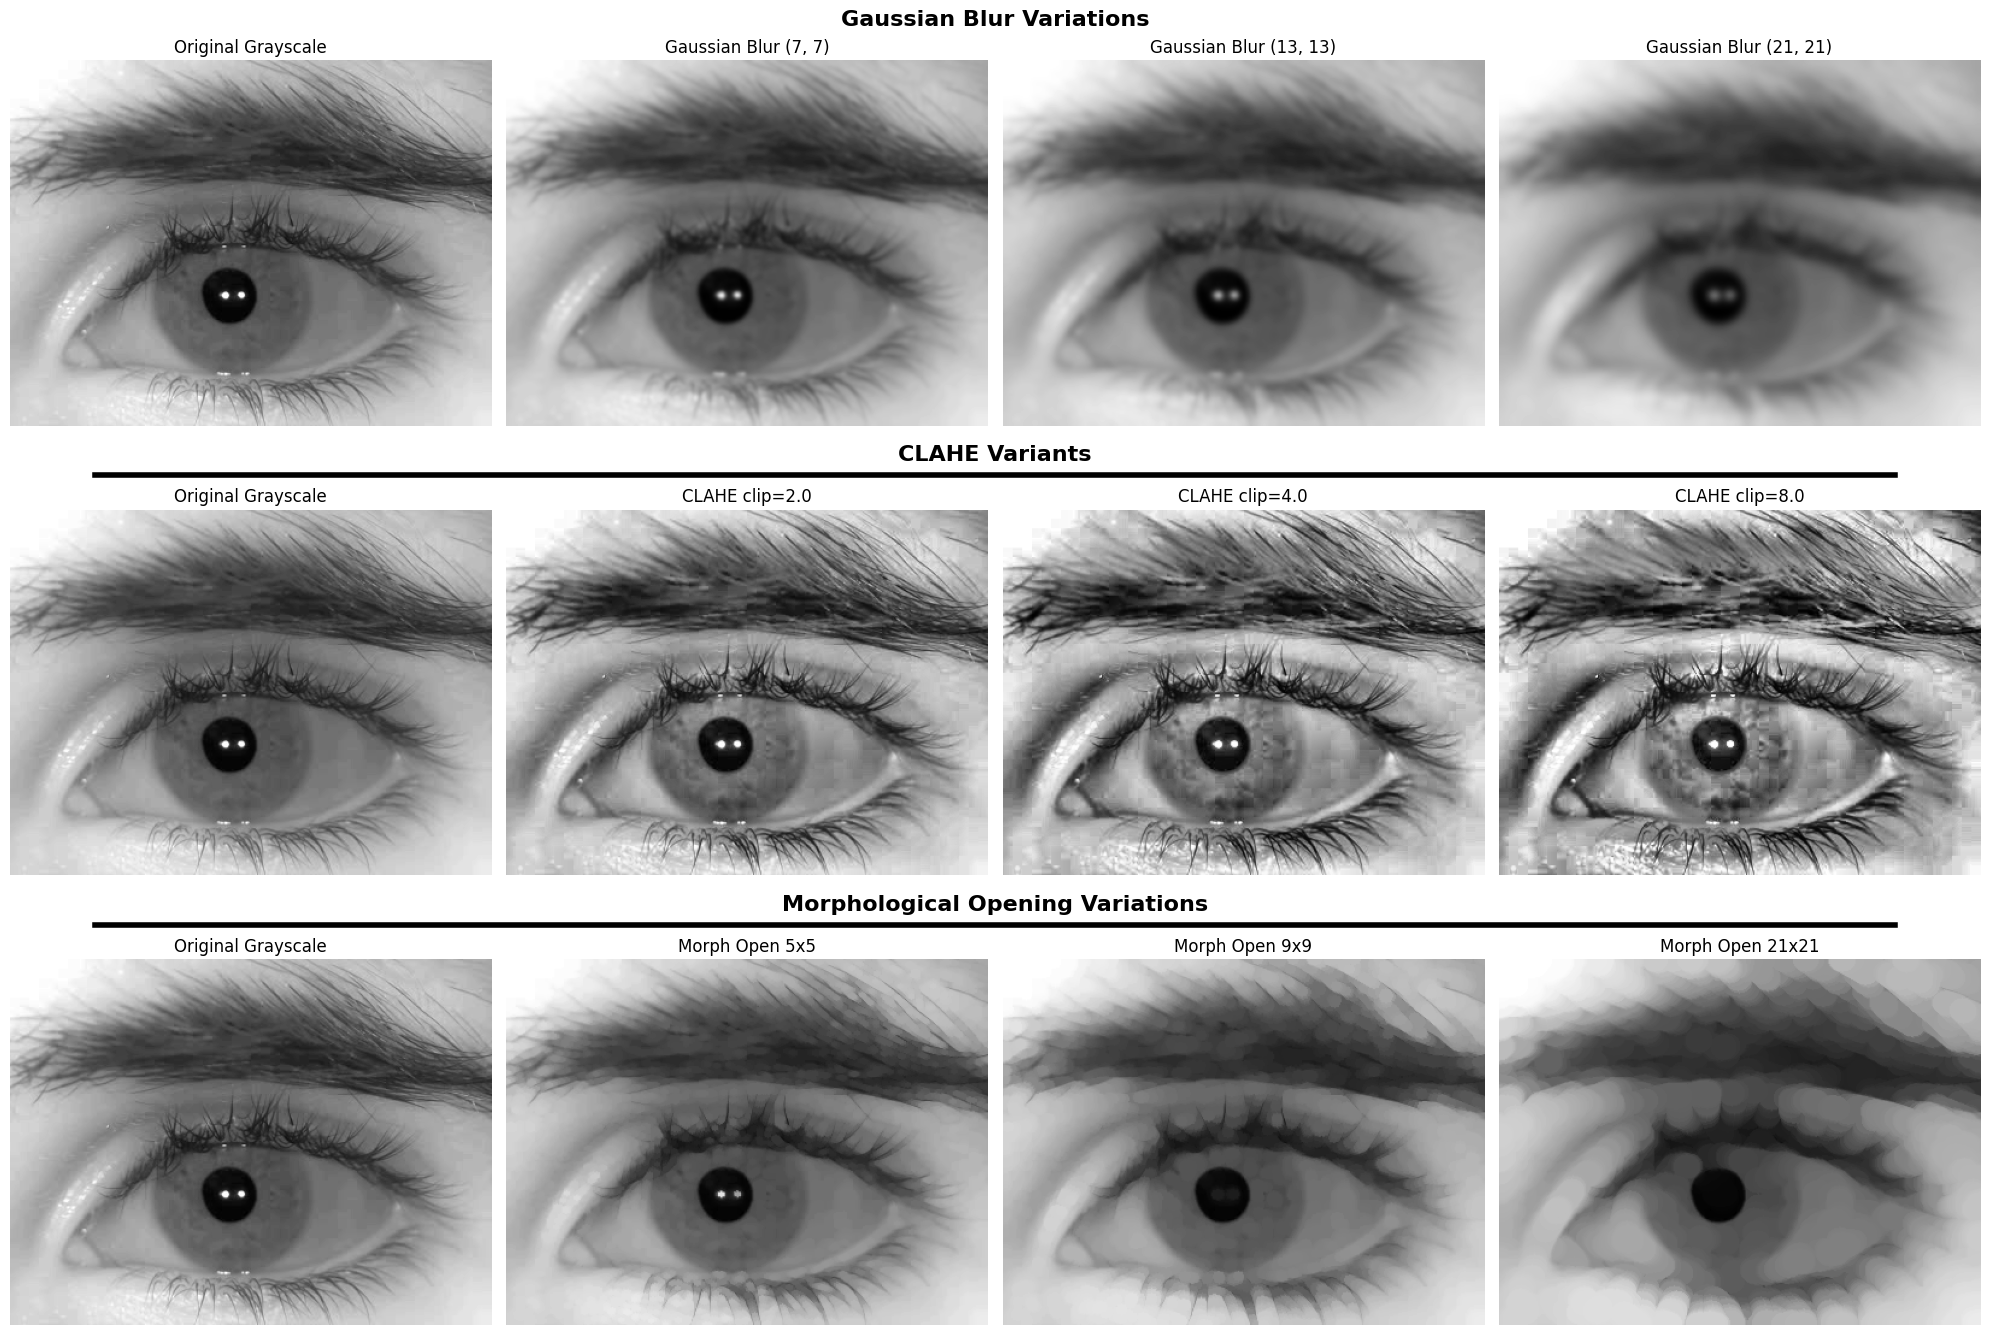

In [5]:
# 1. Gaussian Blur Variations
gaussian_kernel_sizes = [(7, 7), (13, 13), (21, 21)]
blurred_images = [cv2.GaussianBlur(gray_frame, k, 0) for k in gaussian_kernel_sizes]


# 2. CLAHE Variants (without histogram equalization)
clahe_clip2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_frame)
clahe_clip4 = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8)).apply(gray_frame)
clahe_clip8 = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8)).apply(gray_frame)


# 3. Morphological Opening Variations
morph_kernel_sizes = [5, 9, 21]
morph_images = []
for k in morph_kernel_sizes:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    morph = cv2.morphologyEx(gray_frame, cv2.MORPH_OPEN, kernel)
    morph_images.append(morph)

# Call the plotting function to display the figures.
plot_variations(gray_frame, blurred_images, gaussian_kernel_sizes,
                clahe_clip2, clahe_clip4, clahe_clip8,
                morph_images, morph_kernel_sizes)


### a. Thresholding Function
- **Function:** `apply_thresholds(input_image, threshold_values)`
- **Process:**
  - Iterates over a list of threshold values (e.g., `[30, 50, 90, 120]`).
  - For each value, applies binary inverse thresholding (`cv2.THRESH_BINARY_INV`), converting the image into a binary format where pixel intensities below the threshold are set to 255 and those above to 0.
- **Output:** A list of tuples containing the threshold value and the corresponding thresholded binary image.


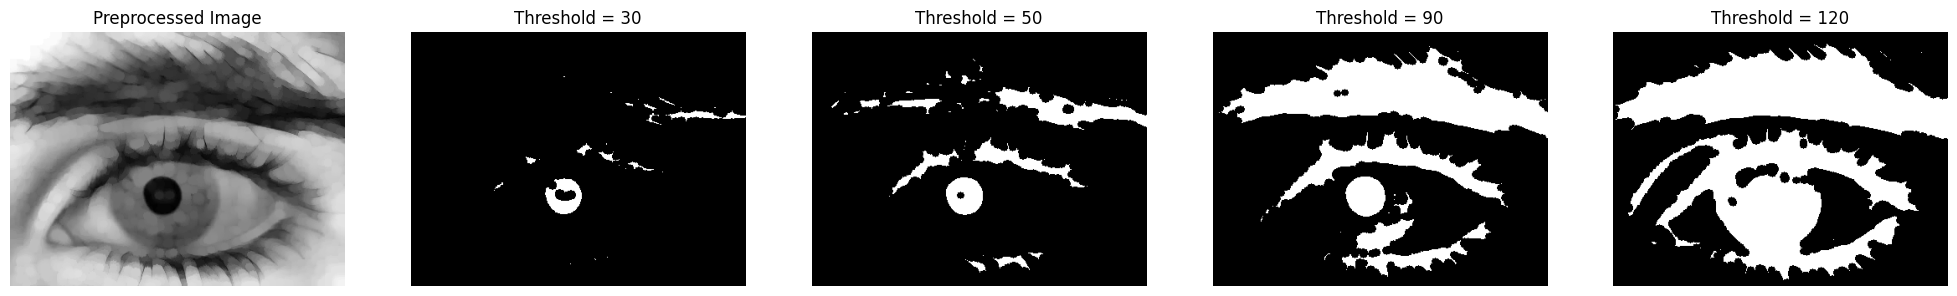

In [25]:
def apply_thresholds(input_image, threshold_values):
    thresholded_images = []
    for val in threshold_values:
        _, thresh = cv2.threshold(input_image, val, 255, cv2.THRESH_BINARY_INV)
        thresholded_images.append((val, thresh))
    return input_image, thresholded_images

def show_threshold_examples(base_image, thresholded_images):
    n = len(thresholded_images)
    fig, axes = plt.subplots(1, n+1, figsize=(5*(n+1), 5))
    axes[0].imshow(base_image, cmap='gray')
    axes[0].set_title("Preprocessed Image")
    axes[0].axis('off')
    for i, (val, img) in enumerate(thresholded_images):
        axes[i+1].imshow(img, cmap='gray')
        axes[i+1].set_title(f"Threshold = {val}")
        axes[i+1].axis('off')
    plt.show()


# Apply blur
blur_value = 5
blurred_frame = cv2.GaussianBlur(gray_frame, (blur_value, blur_value), 0)

# Apply CLAHE
clahe_value = 6
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(clahe_value, clahe_value))
clahe_applied = clahe.apply(gray_frame)

# Morphological Opening
kernel_value = 9
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_value, kernel_value))
morph = cv2.morphologyEx(clahe_applied, cv2.MORPH_OPEN, kernel)


threshold_values = [30, 50, 90, 120]
morph_image, thresholded_imgs = apply_thresholds(morph, threshold_values)
show_threshold_examples(morph_image, thresholded_imgs)


### b. Contouring

1. **Contour Extraction**
   - The thresholded image is processed with `cv2.findContours` to extract the external contours.
   - Contours represent the boundaries of distinct objects in the image.

2. **Selecting the Largest Contour**
   - Among the detected contours, the largest one (by area) is assumed to be the pupil.
   - The minimum enclosing circle of this contour is computed, giving the center `(x, y)` and the radius `r` of the circle that best fits the contour.



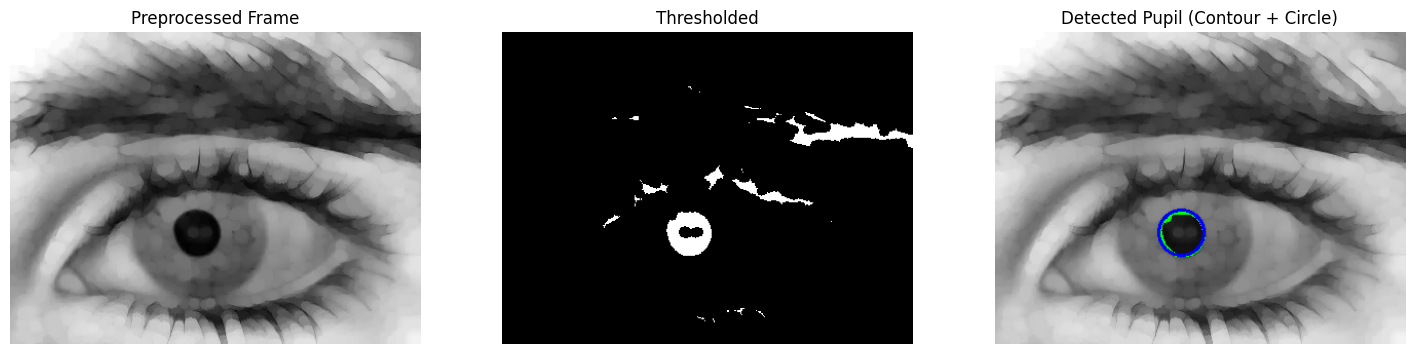

In [27]:
# Thresholding
threshold_value = 35
_, thresholded = cv2.threshold(morph_image, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select and draw largest contour
if contours:
    largest = max(contours, key=cv2.contourArea)
    (x, y), r = cv2.minEnclosingCircle(largest)

    # ✅ Draw on a fresh copy of the original frame (color image)
    output_image = cv2.cvtColor(morph_image.copy(), cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_image, [largest], -1, (0, 255, 0), 2)
    cv2.circle(output_image, (int(x), int(y)), int(r), (255, 0, 0), 2)

    # ✅ Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(morph_image, cmap='gray')
    axes[0].set_title("Preprocessed Frame")

    axes[1].imshow(thresholded, cmap='gray')
    axes[1].set_title("Thresholded")

    axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Detected Pupil (Contour + Circle)")

    for ax in axes:
        ax.axis('off')
    plt.show()
else:
    print("No contours found.")


# Pupil detection in Video

This cell processes an entire video frame-by-frame to detect the pupil using a combination of image preprocessing techniques and contour analysis. The workflow includes several key steps:

## 1. Video Capture
- **Video Loading:** The video file is opened using `cv2.VideoCapture`.
- **Frame Iteration:** Each frame is read in a loop until the video ends.

## 2. Frame Preprocessing
For every frame:
- **Grayscale Conversion:** The frame is converted to grayscale.
- **Noise Reduction:** A Gaussian blur (with a kernel size defined by `blur_value`) is applied to reduce noise.
- **Contrast Enhancement:** CLAHE (Contrast Limited Adaptive Histogram Equalization) is used with parameters (`clahe_value`) to enhance local contrast.
- **Morphological Filtering:** Morphological opening is performed using an elliptical kernel (defined by `kernel_value`) to remove small artifacts.

## 3. Thresholding and Contour Detection
- **Thresholding:** A binary inverse threshold is applied using a fixed `threshold_value`, which produces a binary image that isolates dark regions.
- **Contour Extraction:** Contours are extracted from the thresholded image using `cv2.findContours`.
- **Pupil Identification:** If contours are found, the largest contour is assumed to represent the pupil. The minimum enclosing circle of this contour is computed to estimate the pupil's radius.

## 4. Data Storage and Post-Processing
- **Radius Collection:** The detected pupil radius for each frame is appended to the `pupil_radii` list.
- **Frame Data Storage:** A dictionary `frame_data` is used to store the full processing details for each frame, including:
  - The original frame.
  - The thresholded image.
  - The detected contour.
  - The computed radius.
- **Final Conversion:** The list of pupil radii is converted to a NumPy array for further analysis.
- **Summary:** A print statement indicates the number of processed frames and confirms that all frame data has been stored.



In [28]:

pupil_radii = []
frame_data = {}  # Store full data for each frame
frame_idx = 0

cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (blur_value, blur_value), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(clahe_value, clahe_value)).apply(blurred)
    morph = cv2.morphologyEx(clahe, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_value, kernel_value)))
    _, thresholded = cv2.threshold(morph, threshold_value, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    radius = None
    largest = None
    if contours:
        largest = max(contours, key=cv2.contourArea)
        (_, _), r = cv2.minEnclosingCircle(largest)
        radius = r

    pupil_radii.append(radius)

    # Store data
    frame_data[frame_idx] = {
        "original": frame.copy(),
        "thresholded": thresholded.copy(),
        "contour": largest,
        "radius": radius
    }

    frame_idx += 1

cap.release()

# Convert to NumPy array for later use
pupil_radii = np.array(pupil_radii, dtype=np.float32)

print(f"Processed {len(pupil_radii)} frames. Stored full data for inspection.")


Processed 321 frames. Stored full data for inspection.


# Peak detection
Finds the peaks in the calculated pupil_radii

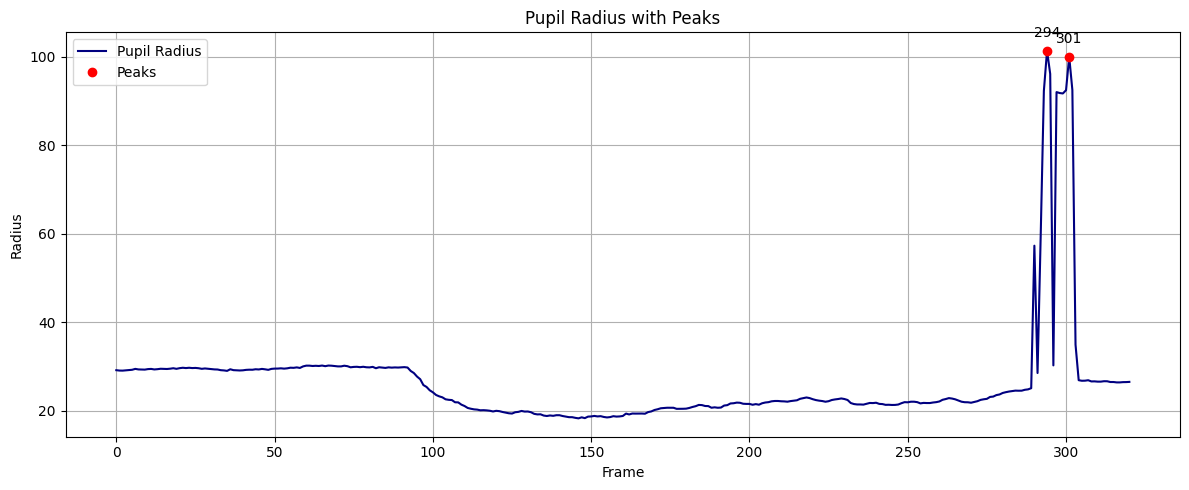

🔍 Peak frames: [294 301]


In [29]:
# Find peaks
peaks, _ = find_peaks(pupil_radii, prominence=10, distance=5)

plt.figure(figsize=(12, 5))
plt.plot(pupil_radii, label="Pupil Radius", color='navy')
plt.plot(peaks, pupil_radii[peaks], "ro", label="Peaks")
for peak in peaks:
    plt.annotate(str(peak), (peak, pupil_radii[peak]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title("Pupil Radius with Peaks")
plt.xlabel("Frame")
plt.ylabel("Radius")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("🔍 Peak frames:", peaks)


# Inspect peak frame
Fill in the frame_number to a peak value to inspect the frame

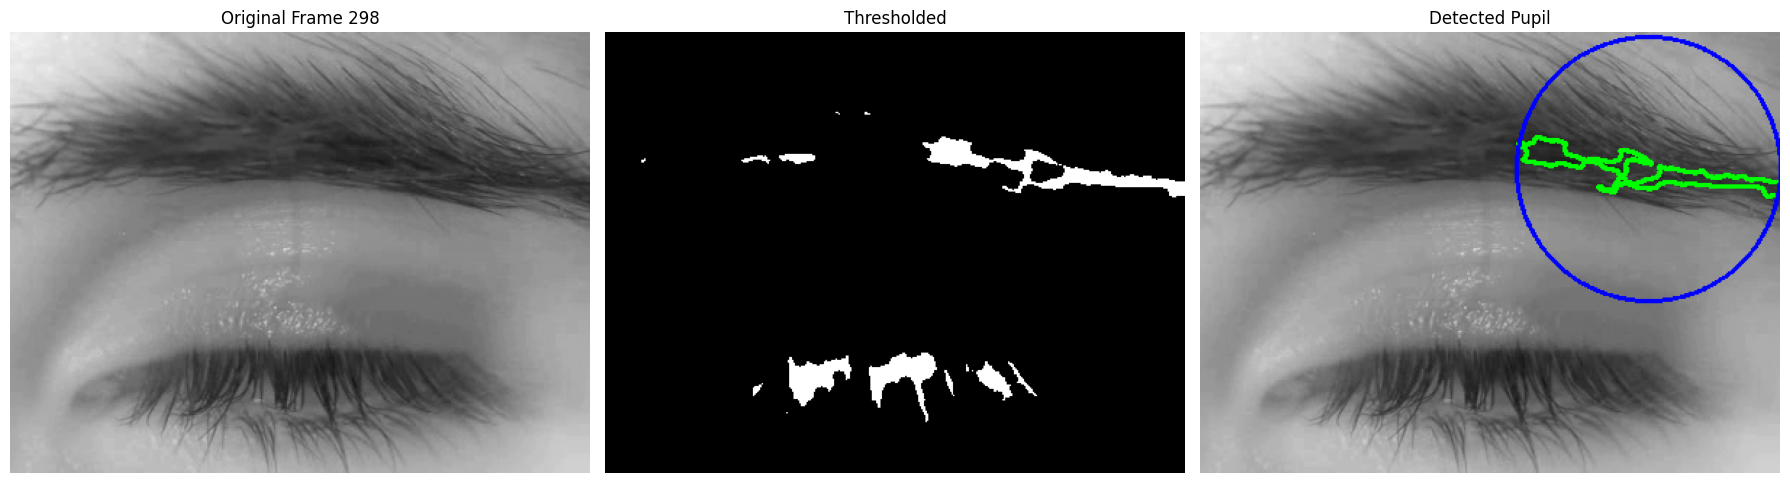

In [30]:
# Inspect a specific frame after peak detection
frame_number = 298  # or any peak from the previous cell

data = frame_data[frame_number]
frame = data["original"]
thresholded = data["thresholded"]
contour = data["contour"]

# Draw on a copy
output = frame.copy()
if contour is not None:
    (x, y), r = cv2.minEnclosingCircle(contour)
    cv2.drawContours(output, [contour], -1, (0, 255, 0), 2)
    cv2.circle(output, (int(x), int(y)), int(r), (255, 0, 0), 2)

# Plot all 3
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Original Frame {frame_number}")
axes[0].axis("off")

axes[1].imshow(thresholded, cmap="gray")
axes[1].set_title("Thresholded")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[2].set_title("Detected Pupil")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# Select range
Select the range of frames that is interest, in our case the range where the pupil is accommodating

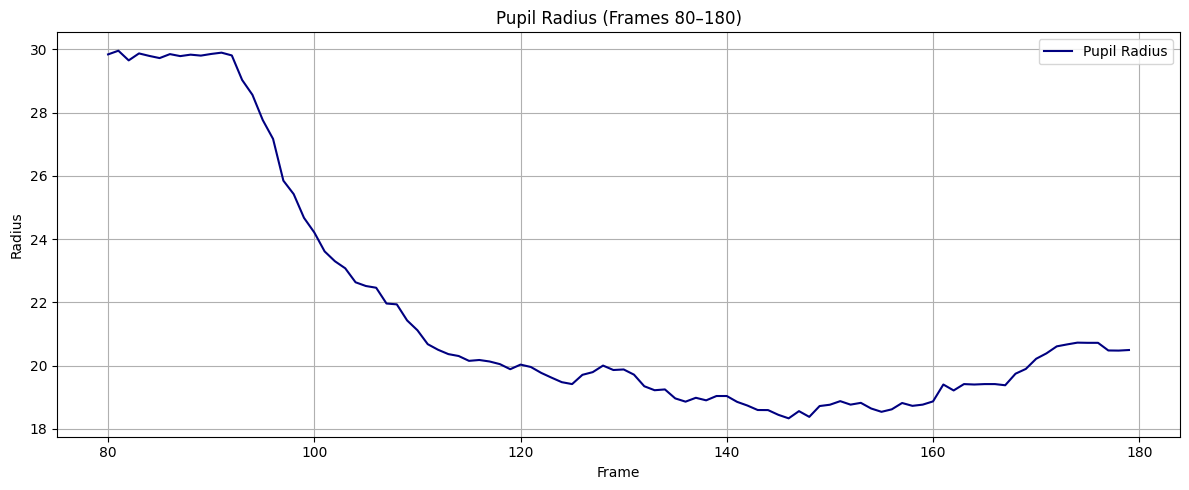

In [31]:
start_frame = 80
end_frame = 180

plt.figure(figsize=(12, 5))
plt.plot(range(start_frame, end_frame), pupil_radii[start_frame:end_frame], label="Pupil Radius", color='navy')
plt.title(f"Pupil Radius (Frames {start_frame}–{end_frame})")
plt.xlabel("Frame")
plt.ylabel("Radius")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Curve Fitting
Defined are some fitting models, like:
- **Linear Fit:**
- **Exponential Fit:**
- **Power Fit:**

Apply the different fits on the selected data, and determine which one is the best fit. More fitting models are possible, as well as varying the threshold values of the fitting models to find the perfect fit.


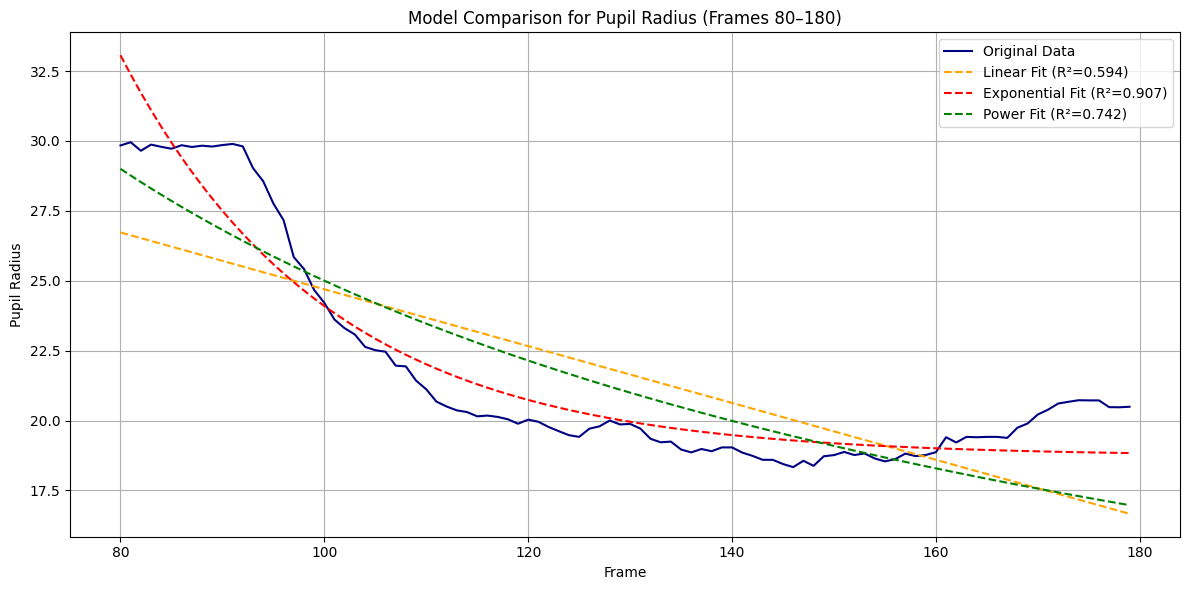

📊 Model Fit Summary (Higher R² is better):
- Linear Fit: R² = 0.5935
- Exponential Fit: R² = 0.9068
- Power Fit: R² = 0.7423

✅ Best fit: Exponential (R² = 0.9068)

✅ Best fit: Exponential (R² = 0.9068)


In [37]:

# --- Models ---
def linear_model(x, a, b):
    return a * x + b

def exp_model(x, a, b, c):
    return a * np.exp(-b * x) + c

def power_model(x, a, b):
    return a * np.power(x, b)

def fit_model(x, y, model_func, p0=None):
    params, _ = curve_fit(model_func, x, y, p0=p0, maxfev=10000)
    y_fit = model_func(x, *params)
    r2 = r2_score(y, y_fit)
    return y_fit, params, r2



# Slice the relevant data
x = np.arange(start_frame, end_frame)
y = pupil_radii[start_frame:end_frame]

# --- Fit each model ---
fits = {}

# Linear
fit_lin, params_lin, r2_lin = fit_model(x, y, linear_model)
fits['Linear'] = {'y': fit_lin, 'r2': r2_lin, 'params': params_lin}

# Exponential
fit_exp, params_exp, r2_exp = fit_model(x, y, exp_model, p0=[30, 0.05, 20])
fits['Exponential'] = {'y': fit_exp, 'r2': r2_exp, 'params': params_exp}

# Power fit
fit_power, params_power, r2_power = fit_model(x, y, power_model, p0=[1, 1])
fits['Power'] = {'y': fit_power, 'r2': r2_power, 'params': params_power}

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Original Data', color='navy')

colors = {'Linear': 'orange', 'Exponential': 'red', 'Power': 'green'}

for name, result in fits.items():
    plt.plot(x, result['y'], label=f"{name} Fit (R²={result['r2']:.3f})", linestyle='--', color=colors[name])

plt.title("Model Comparison for Pupil Radius (Frames 80–180)")
plt.xlabel("Frame")
plt.ylabel("Pupil Radius")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print summary ---
print("📊 Model Fit Summary (Higher R² is better):")
for name, result in fits.items():
    print(f"- {name} Fit: R² = {result['r2']:.4f}")

# --- Best model ---
best_model = max(fits.items(), key=lambda x: x[1]['r2'])
print(f"\n✅ Best fit: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")
print(f"\n✅ Best fit: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")



### Save Lecture Information
# This cell saves the key details of the video processing

In [43]:

# Save analysis settings to a text file
with open("analysis_info.txt", "w") as f:
    f.write("Analysis Settings and Results\n")
    f.write("-----------------------------\n")
    f.write(f"Gaussian Blur Kernel Size: {blur_value}\n")
    f.write(f"CLAHE Tile Grid Size: [{clahe_value}, {clahe_value}]\n")
    f.write(f"Morphological Opening Kernel Size: {kernel_value}\n")
    f.write(f"Threshold Value: {threshold_value}\n")
    f.write(f"Selected Frames: Start = {start_frame}, End = {end_frame}\n")
    f.write(f"Best Model: {best_model[0]}\n")
    f.write(f"R2 Value: {best_model[1]}\n")

print("Analysis settings and results saved to analysis_info.txt")

# Save the pupil_radii NumPy array as a CSV file
np.savetxt("pupil_radii.csv", pupil_radii, delimiter=",")
print("Pupil radii saved to pupil_radii.csv")


Analysis settings and results saved to analysis_info.txt
Pupil radii saved to pupil_radii.csv
